<a href="https://colab.research.google.com/github/ObjectMatrix/google-colab-notebook/blob/main/sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Employee Preferences in the Post-Pandemic Era

In [ ]:
!pip install transformers
!pip install pandas

In [ ]:
!pip install numpy pandas tensorflow matplotlib seaborn
!pip install emoji

In [ ]:
#optional
!pip install jupyter-datatables
!pip install ipyannotate
!pip install jupyternotify

First Try with Logistic **Regression**

In [ ]:
import pandas as pd
from transformers import pipeline, AutoTokenizer

path = "/content/drive/MyDrive/sentiment/sentiment.xlsx"
df_sentiment = pd.read_excel(path)
comment_likes = df_sentiment[["likes", "comment"]]

# Load the sentiment analysis model
sentiment_analysis = pipeline("sentiment-analysis")

# Load the tokenizer corresponding to the sentiment analysis model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# Open a file to write the results
output_file = "/content/drive/MyDrive/sentiment/sentiment_results.txt"
with open(output_file, "w") as f:
    # Iterate over the rows of the df_sentiment dataframe
    for index, row in df_sentiment.iterrows():
        comment = row["comment"]
        likes = row["likes"]

        # Tokenize the comment, get input ids
        input_ids = tokenizer.encode(comment, truncation=False)

        # Split into chunks of max_length tokens
        chunks = []
        for i in range(0, len(input_ids), 512 - 2):  # we subtract 2 for [CLS] and [SEP]
            chunks.append(input_ids[i:i + 512 - 2])

        # Analyze sentiment of each chunk and average the scores
        sentiment_scores = []
        for chunk in chunks:
            # Convert input ids back to text
            chunk_text = tokenizer.decode(chunk)
            result = sentiment_analysis(chunk_text)
            sentiment_scores.append(result[0]['score'])
        sentiment_score = sum(sentiment_scores) / len(sentiment_scores)
        
        # Get the sentiment prediction of the first chunk as the overall prediction
        first_chunk_text = tokenizer.decode(chunks[0])
        sentiment_label = sentiment_analysis(first_chunk_text)[0]['label']

        # Adjust sentiment score based on likes
        weighted_score = sentiment_score * (likes / 100)

        # Write the sentiment prediction with weighted score to the file
        f.write(f"Comment: {comment}\n")
        f.write(f"Sentiment: {sentiment_label}\n")
        f.write(f"Original Score: {sentiment_score}\n")
        f.write(f"Likes: {likes}\n")
        f.write(f"Weighted Score: {weighted_score}\n")
        f.write("\n")


**GRAPH: POSITIVE-NEGATIVE-NEUTRAL: This Model does better**

In [ ]:
import pandas as pd
from transformers import pipeline, AutoTokenizer
import matplotlib.pyplot as plt
from collections import Counter

path = "/content/drive/MyDrive/sentiment/sentiment.xlsx"
df_sentiment = pd.read_excel(path)
comment_likes = df_sentiment[["likes", "comment"]]

# Load the sentiment analysis model
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
sentiment_analysis = pipeline("sentiment-analysis", model=model_name)

# Load the tokenizer corresponding to the sentiment analysis model
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Open a file to write the results
output_file = "/content/drive/MyDrive/sentiment/sentiment_results_neutral.txt"

# A list to store sentiment labels for later use in plotting
sentiment_labels = []

with open(output_file, "w") as f:
    # Iterate over the rows of the df_sentiment dataframe
    for index, row in df_sentiment.iterrows():
        comment = row["comment"]
        likes = row["likes"]

        # Tokenize the comment, get input ids
        input_ids = tokenizer.encode(comment, truncation=False)

        # Split into chunks of max_length tokens
        chunks = []
        for i in range(0, len(input_ids), 512 - 2):  # we subtract 2 for [CLS] and [SEP]
            chunks.append(input_ids[i:i + 512 - 2])

        # Analyze sentiment of each chunk and average the scores
        sentiment_scores = []
        for chunk in chunks:
            # Convert input ids back to text
            chunk_text = tokenizer.decode(chunk)
            result = sentiment_analysis(chunk_text)
            sentiment_scores.append(result[0]['score'])
            sentiment_labels.append(result[0]['label'])
        sentiment_score = sum(sentiment_scores) / len(sentiment_scores)
        
        # Get the sentiment prediction of the first chunk as the overall prediction
        first_chunk_text = tokenizer.decode(chunks[0])
        sentiment_label = sentiment_analysis(first_chunk_text)[0]['label']

        # Adjust sentiment score based on likes
        weighted_score = sentiment_score * (likes / 100)
        sentiment_score_with_weight = sentiment_score + weighted_score
        # Write the sentiment prediction with weighted score to the file
        f.write(f"Comment: {comment}\n")
        f.write(f"Sentiment: {sentiment_label}\n")
        f.write(f"sentimentPlusWeight: {sentiment_score_with_weight}\n")
        f.write(f"Original Score: {sentiment_score}\n")
        f.write(f"Likes: {likes}\n")
        f.write(f"Weighted Score: {weighted_score}\n")
        f.write("\n")

# Count the sentiment labels
label_counts = Counter(sentiment_labels)

# Plot a bar chart of the label counts
plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values())
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


👍 Include **LIKEs** Count

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


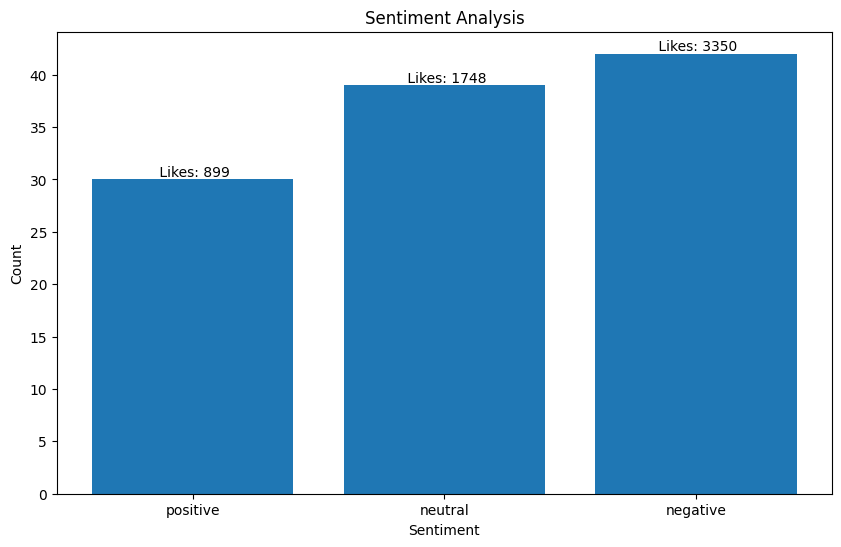

In [12]:
import pandas as pd
from transformers import pipeline, AutoTokenizer
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

path = "/content/drive/MyDrive/sentiment/sentiment.xlsx"
df_sentiment = pd.read_excel(path)
comment_likes = df_sentiment[["likes", "comment"]]

# Load the sentiment analysis model
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
sentiment_analysis = pipeline("sentiment-analysis", model=model_name)

# Load the tokenizer corresponding to the sentiment analysis model
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Open a file to write the results
output_file = "/content/drive/MyDrive/sentiment/sentiment_results_neutral.txt"

# A list to store sentiment labels for later use in plotting
sentiment_labels = []
likes_dict = defaultdict(int)

with open(output_file, "w") as f:
    # Iterate over the rows of the df_sentiment dataframe
    for index, row in df_sentiment.iterrows():
        comment = row["comment"]
        likes = row["likes"]

        # Tokenize the comment, get input ids
        input_ids = tokenizer.encode(comment, truncation=False)

        # Split into chunks of max_length tokens
        chunks = []
        for i in range(0, len(input_ids), 512 - 2):  # we subtract 2 for [CLS] and [SEP]
            chunks.append(input_ids[i:i + 512 - 2])

        # Analyze sentiment of each chunk and average the scores
        sentiment_scores = []
        for chunk in chunks:
            # Convert input ids back to text
            chunk_text = tokenizer.decode(chunk)
            result = sentiment_analysis(chunk_text)
            sentiment_scores.append(result[0]['score'])
            sentiment_labels.append(result[0]['label'])
            likes_dict[result[0]['label']] += likes
        sentiment_score = sum(sentiment_scores) / len(sentiment_scores)
        
        # Get the sentiment prediction of the first chunk as the overall prediction
        first_chunk_text = tokenizer.decode(chunks[0])
        sentiment_label = sentiment_analysis(first_chunk_text)[0]['label']

        # Adjust sentiment score based on likes
        weighted_score = sentiment_score * (likes / 100)
        sentiment_score_with_weight = sentiment_score + weighted_score
        # Write the sentiment prediction with weighted score to the file
        f.write(f"Comment: {comment}\n")
        f.write(f"Sentiment: {sentiment_label}\n")
        f.write(f"sentimentPlusWeight: {sentiment_score_with_weight}\n")
        f.write(f"Original Score: {sentiment_score}\n")
        f.write(f"Likes: {likes}\n")
        f.write(f"Weighted Score: {weighted_score}\n")
        f.write("\n")

# Count the sentiment labels
label_counts = Counter(sentiment_labels)

# Plot a bar chart of the label counts
plt.figure(figsize=(10, 6))
bars = plt.bar(label_counts.keys(), label_counts.values())
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Add the total like counts for each sentiment group
for bar, sentiment in zip(bars, label_counts.keys()):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
             f" Likes: {likes_dict[sentiment]}", 
             ha='center', va='bottom')
plt.show()
